Copyright (c) 2015, 2016 [Sebastian Raschka](sebastianraschka.com)
<br>
2016 [Li-Yi Wei](http://www.liyiwei.org/)

https://github.com/1iyiwei/pyml

[MIT License](https://github.com/1iyiwei/pyml/blob/master/LICENSE.txt)

# Python Machine Learning - Code Examples

# Chapter 11 - Working with Unlabeled Data – Clustering Analysis

Supervised learning
* classification
<img src = "./images/01_03.png">
* regression
<img src = "./images/01_04.png" width=50%>

Unsupervised learning
* dimensionality reduction
<img src="./images/01_07.png">
* clustering
<img src="./images/01_06.png" width=50%>

Note that the optional watermark extension is a small IPython notebook plugin that I developed to make the code reproducible. You can just skip the following line(s).

In [1]:
%load_ext watermark
%watermark -a '' -u -d -v -p numpy,pandas,matplotlib,scipy,sklearn

last updated: 2016-11-15 

CPython 3.5.2
IPython 4.2.0

numpy 1.11.1
pandas 0.18.1
matplotlib 1.5.1
scipy 0.17.1
sklearn 0.18


*The use of `watermark` is optional. You can install this IPython extension via "`pip install watermark`". For more information, please see: https://github.com/rasbt/watermark.*

### Overview

- [Grouping objects by similarity using k-means](#Grouping-objects-by-similarity-using-k-means)
  - [K-means++](#K-means++)
  - [Hard versus soft clustering](#Hard-versus-soft-clustering)
  - [Using the elbow method to find the optimal number of clusters](#Using-the-elbow-method-to-find-the-optimal-number-of-clusters)
  - [Quantifying the quality of clustering via silhouette plots](#Quantifying-the-quality-of-clustering-via-silhouette-plots)
- [Organizing clusters as a hierarchical tree](#Organizing-clusters-as-a-hierarchical-tree)
  - [Performing hierarchical clustering on a distance matrix](#Performing-hierarchical-clustering-on-a-distance-matrix)
  - [Attaching dendrograms to a heat map](#Attaching-dendrograms-to-a-heat-map)
  - [Applying agglomerative clustering via scikit-learn](#Applying-agglomerative-clustering-via-scikit-learn)
- [Locating regions of high density via DBSCAN](#Locating-regions-of-high-density-via-DBSCAN)
- [Summary](#Summary)

In [2]:
from IPython.display import Image

In [3]:
%matplotlib inline

# Grouping objects by similarity using k-means

Cluster similar objects (data samples) $\mathbf{X}$ together
* documents, music, video
* users with similar profiles or interests

The number of cluster (k) is a hyper-parameter
* manual specification
* automatic determination

The distance measure $d(x^{(i)}, x^{(j)})$ can be another hyper-parameter
* Euclidean ($L_2$) is a common choice

<img src="./images/01_06.png" width=50%>

## K-means clustering example

### Create and visualize the data set

In [4]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=150, 
                  n_features=2, 
                  centers=3, 
                  cluster_std=0.5, 
                  shuffle=True, 
                  random_state=0)

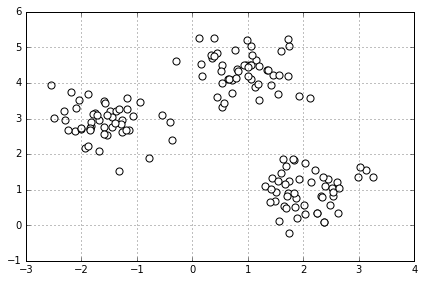

In [5]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c='white', marker='o', s=50)
plt.grid()
plt.tight_layout()
#plt.savefig('./figures/spheres.png', dpi=300)
plt.show()

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# global plot options for consistency
def plot_options():
    markers = ('s', 'x', 'o', '^', 'v')
    #colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    colors = ['lightgreen', 'orange', 'lightblue', 'gray', 'cyan']
    center_marker = '*'
    center_color = 'red'
    
    return markers, colors, center_marker, center_color

def plot_clusters(X, y, centers):
    
    markers, colors, center_marker, center_color = plot_options()
    
    num_clusters = np.unique(y).shape[0]
    
    for k in range(num_clusters):
        color = colors[k]
        marker = markers[k]
        plt.scatter(X[y == k, 0], X[y == k, 1], 
                    s=50, c=color, marker=marker,
                    label = 'cluster ' + str(k+1))
    
    plt.scatter(centers[:, 0], centers[:, 1],
                s=250, marker=center_marker, c=center_color, 
                label='centroids')

In [7]:
# same code from the classifiers
# applicable to any model with predict() method
# here, y is the cluster labels, 
# instead of ground truth as in supervised classification
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, model, resolution=0.02):

    # setup marker generator and color map
    
    markers, colors, center_marker, center_color = plot_options()
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = model.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

### First iteration

Not good clustering

### More iterations

Better clustering results

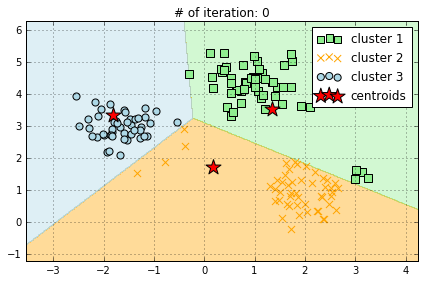

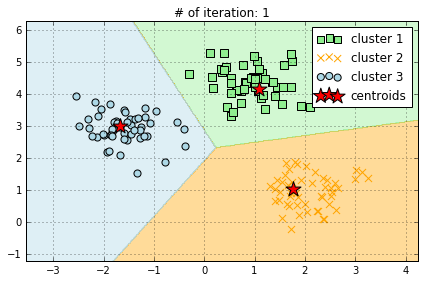

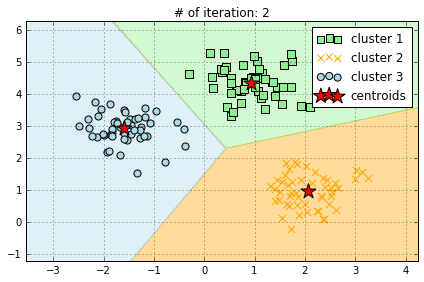

In [8]:
from sklearn.cluster import KMeans

num_clusters = 3
num_iterations = 3

for iteration in range(num_iterations):
    km = KMeans(n_clusters=num_clusters, 
                init='random',
                n_init=1, 
                max_iter=iteration+1,
                tol=1e-04,
                random_state=0)
    y_km = km.fit_predict(X)

    plot_decision_regions(X, y_km, km)
    plot_clusters(X, y_km, km.cluster_centers_)
    plt.legend()
    plt.title('# of iteration: ' + str(iteration))
    plt.grid()
    plt.tight_layout()
    plt.show()

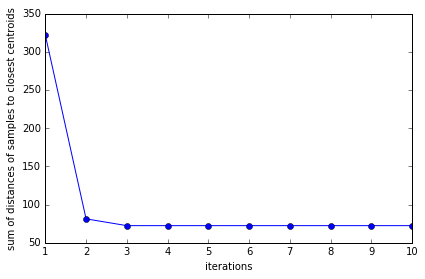

In [9]:
# estimate inertia, i.e. sum of distances from samples to nearest cluster centers

num_trials = 5
num_iterations = 10

inertia = np.zeros(num_iterations)

for iteration in range(num_iterations):
    cost = 0
    for trial in range(num_trials):
        km = KMeans(n_clusters=num_clusters, 
                    init='random',
                    n_init=1, 
                    max_iter=iteration+1,
                    tol=1e-04,
                    random_state=0)
        y_km = km.fit_predict(X)
        cost = cost + km.inertia_
    inertia[iteration] = cost/num_trials
    
#print(inertia)

plt.plot(range(1, len(inertia)+1), inertia, marker='o')
plt.xlabel('iterations')
plt.ylabel('sum of distances of samples to closest centroids')
plt.tight_layout()
plt.show()

## K-means clustering algorithm

Input: a set of samples $\mathbf{X}$
* without labels $\mathbf{y}$ as in supervised classification

Distance measure: assume $L_2$ for simplicity and commonality
$$
\begin{align}
d\left(x^{(i)}, x^{(j)}\right) 
&= \|x^{(i)} - x^{(j)} \|_2
\\
&= \sqrt{\sum_k \left(x^{(i)}_k - x^{(j)}_k \right)^2}
\end{align}
$$

Steps:
* Initialization: pick (e.g. randomly) $k$ centroids $\mathbf{U} = \{\mu^{(j)}\}, j \in \{1, \cdots, k \}$ from $\mathbf{X}$ as initial cluster centers 

* Voronoi: assign each sample $x^{(i)} \in \mathbf{X}$ to the nearest centroid $\mu\left(x^{(i)}\right)$
$$
\begin{align}
\mu\left(x^{(i)}\right) = argmin_{\mu \in \mathbf{U}} d(x^{(i)}, \mu)
\end{align}
$$

* Centroid: move each $\mu^{(j)} \in \mathbf{U}$ to the center of the samples that were assigned to it (i.e. the cluster of $\mu^{(j)}$)
$$
\begin{align}
\mu^{(j)} &= \frac{1}{\sum w_{ij}} \sum w_{ij} x^{(i)} 
\\
w_{ij} &=
\begin{cases}
1 \; if \mu\left( x^{(i)}\right) = \mu^{(j)}
\\
0 \; else
\end{cases}
\end{align}
$$

* Repeat the Vornoi and centroid steps until the cluster assignments do not change much or a maximum number of iterations is reached

## Visualizing the clustering process

https://www.youtube.com/watch?v=S0sAnabdCLg

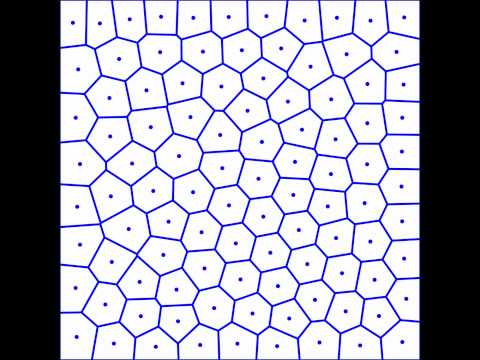

In [10]:
from IPython.display import YouTubeVideo
YouTubeVideo('S0sAnabdCLg')

## aka <a href="https://en.wikipedia.org/wiki/Lloyd%27s_algorithm">Lloyd's algorithm</a>

Maroon dot: previous centers

Black cross: next centers

Iteration 1:
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/5a/LloydsMethod1.svg/200px-LloydsMethod1.svg.png">

Iteration 2:
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/77/LloydsMethod2.svg/200px-LloydsMethod2.svg.png">

Iteration 3:
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/fb/LloydsMethod3.svg/200px-LloydsMethod3.svg.png">

Iteration 15:
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/3b/LloydsMethod15.svg/200px-LloydsMethod15.svg.png">

## Background and intuition

$\mathbf{X} = \{x^{(i)}\}$: data samples

$\mathbf{U} = \{\mu^{(j)} \}$: cluster centers

The goal is to minimize the following objective function:
$$
\begin{align}
E\left(\mathbf{X} , \mathbf{U} \right)
&=
\sum_i \sum_j w_{ij} d^2\left(x^{(i)}, \mu^{(j)}\right)
\end{align}
$$
Subject to the constraint that each sample is assigned to one cluster:
$$
\begin{align}
\sum_j w_{ij} &= 1
\\
w_{ij} &\in \{0,  1\}
\end{align}
$$

Intuitively, we want to find a set of centroids (cluster centers) $\mathbf{U}$ to minimize the total distance of each sample $x^{(i)} \in \mathbf{X}$ with the nearest centroid $\mu^{(j)} \in \mathbf{U}$.

So that the clusters are as tight as possible.

For $L_2$ distance we have
$$
\begin{align}
E\left(\mathbf{X} , \mathbf{U} \right)
&=
\sum_i \sum_j w_{ij} \|x^{(i)} - \mu^{(j)}\|^2
\\
&=
\sum_j \sum_i w_{ij} \|x^{(i)} - \mu^{(j)} \|^2
\end{align}
$$

<a href="https://en.wikipedia.org/wiki/Voronoi_diagram">
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/54/Euclidean_Voronoi_diagram.svg/220px-Euclidean_Voronoi_diagram.svg.png" align=right>
</a>

For the <b>Voronoi</b> step, we try to minimize each inner term of the $\sum_i \sum_j$ order:
$$
\begin{align}
\sum_j w_{ij} \| x^{(i)} - \mu^{(j)} \|^2
\end{align}
$$
Note that the constraints on $w_{ij}$ forces us to choose only one $\mu^{(j)}$.

For the <b>centroid</b> step, we try to minimize the inner term of the $\sum_j \sum_i$ order:
$$
\begin{align}
\sum_i w_{ij} \| x^{(i)} - \mu^{(j)} \|^2
\end{align}
$$
Only samples assign to cluster $j$ matters, i.e. $w_{ij} = 1$, so via calculus we know the optimal solution is to put $\mu_{(j)}$ at the center of all $x^{(i)}$ assigned to it.
$$
\begin{align}
\mu^{(j)} &= \frac{1}{\sum w_{ij}} \sum w_{ij} x^{(i)} 
\end{align}
$$

## K-means++ intialization

Random selection 
* might not be the best way to initialize the cluster centers
* badly (unluckily) placed centroids can cause convergence issues
* multiple random initialization can help

More systematic approach
* choose initial cluster centers to be as far away from one another as possible
* sequential process, during which the next cluster center is chosen to be the data sample farthest away from all existing centers

This is just for initialization
* the rest, Vornoi and centroid steps, remain the same

## Example differences for initialization

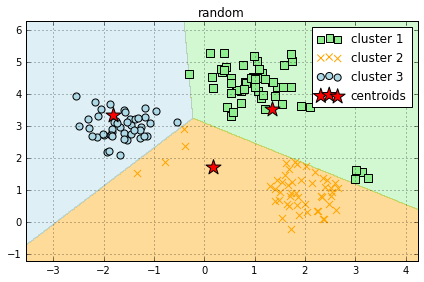

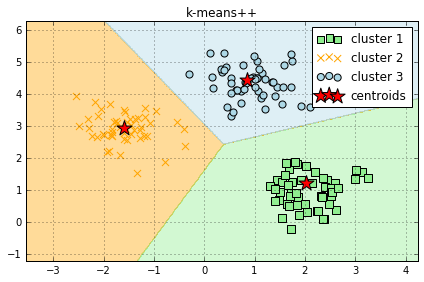

In [11]:
from sklearn.cluster import KMeans

init_options = ['random', 'k-means++']

for init_option in init_options:
    
    km = KMeans(n_clusters=3, 
                init=init_option,
                n_init=1, # just one trial to help visualization
                max_iter=1, # just 1 iteration to help visualize the initial condition
                tol=1e-04,
                random_state=0)
    y_km = km.fit_predict(X)

    plot_decision_regions(X, y_km, km)
    plot_clusters(X, y_km, km.cluster_centers_)
    plt.title(init_option)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

## K-means++ initialization algorithm

$\mathbf{U}$: set of centroids, intially empty:
$\mathbf{U} \leftarrow \emptyset$

$\mathbf{U} \leftarrow x^{(i)} \in \mathbf{X}$ via random selection

While $\|\mathbf{U}\| < k$, the target number of clusters
* compute $d^2\left(x^{(i)}, \mathbf{U} \right)$ for each $x^{(i)} \in \mathbf{X}$ to the nearest member in $\mathbf{U}$
* $\mu^{(j)} \leftarrow$ random selection with probability 
$\frac{d^2\left(x, \mathbf{U} \right)}{\sum_i d^2\left(x^{(i)}, \mathbf{U} \right)}$
for $x \in \mathbf{X}$
* $\mathbf{U} \leftarrow \mathbf{U} \bigcup \mu^{(j)}$

## Challenges with k-means

The number of clusters k is a hyper-parameter
* not easy to pick
* especially in high dimensions when we cannot visualize easily like in 2D

The clusters:
* no overlap (hard instead of soft decision)
* not hierarchical 

We can improve these via other variations of clustering algorithms.

# Hard versus soft clustering

Hard clustering
* each sample is assigned to one cluster

Soft (fuzzy) clustering
* each sample has a probabilistic assignment to all clusters

Main difference: $w_{ij}$, the weight of assigning $x^{(i)}$ to $\mu^{(j)}$
* hard: $w_{ij} \in \{0, 1\}$, binary
* soft: $w_{ij} \in [0, 1]$, continuous

### Objective

$\mathbf{X}$: samples

$\mathbf{U}$: cluster centers

$w_{ij}$: the weight of assigning $x^{(i)}$ to $\mu^{(j)}$

$$
\begin{align}
w_{ij} =
\left[ \sum_{p=1}^{k} \left( \frac{\| x^{(i)} - \mu^{(j)}\|_2}{\| x^{(i)} - \mu^{(p)} \|_2} \right)^{\frac{2}{m-1}} \right]^{-1}
\end{align}
$$

For example, if $k = 3$:
$$
\begin{align}
w_{ij} = 
\left[
\left( \frac{\| x^{(i)} - \mu^{(j)}\|_2}{\| x^{(i)} - \mu^{(1)} \|_2} \right)^{\frac{2}{m-1}}
+
\left( \frac{\| x^{(i)} - \mu^{(j)}\|_2}{\| x^{(i)} - \mu^{(2)} \|_2} \right)^{\frac{2}{m-1}}
+
\left( \frac{\| x^{(i)} - \mu^{(j)}\|_2}{\| x^{(i)} - \mu^{(3)} \|_2} \right)^{\frac{2}{m-1}}
\right]^{-1}
\end{align}
$$

$m$: degree of fuzziness
* $m \in [1, \infty)$
* $m = 1$: hard clustering
* $m > 1$: soft clustering, larger $m$ indicates fuzzier membership

$$
\begin{align}
E\left(\mathbf{X} , \mathbf{U} \right)
&=
\sum_i \sum_j w^m_{ij} \|x^{(i)} - \mu^{(j)}\|_2^2
\end{align}
$$

### Constraints
$$
\begin{align}
\sum_j w_{ij} &= 1
\end{align}
$$

Hard clustering - each sample can be assigned to one cluster
$$
\begin{align}
w_{ij} \in \{0,  1\}
\end{align}
$$

Soft clustering - no additional constraint aside from $[0, 1]$ and the sum to 1 above (probability)

### Example

For 3 clusters

#### Hard clustering:
$
w = 
\begin{pmatrix}
0 \\
1 \\
0
\end{pmatrix}
$

Read: sample belongs to cluster 2

#### Soft clustering:
$
w = 
\begin{pmatrix}
0.10 \\
0.85 \\
0.05
\end{pmatrix}
$

Read: sample is mostly like to belong to cluster 2 with probability $0.85$, but also some chances of belonging to other clusters.

## Fuzzy clustering algorithm

* Initialization: pick (e.g. randomly) $k$ centroids $\mathbf{U} = \{\mu^{(j)}\}, j \in \{1, \cdots, k \}$ from $\mathbf{X}$ as initial cluster centers 

* Voronoi: 
$$
\begin{align}
w_{ij} =
\left[ \sum_{p=1}^{k} \left( \frac{\| x^{(i)} - \mu^{(j)}\|_2}{\| x^{(i)} - \mu^{(p)} \|_2} \right)^{\frac{2}{m-1}} \right]^{-1}
\end{align}
$$

* Centroid:
$$
\begin{align}
\mu^{(j)} =
\frac{\sum_i w^m_{ij} x^{(i)}}{ \sum_i w^m_{ij}}
\end{align}
$$

* Repeat the Vornoi and centroid steps until the cluster assignments do not change much or a maximum number of iterations is reached

Note that when $m=1$, the above reduces to hard clustering.

What is the effect of $m$ on the Voronoi step?
* $m = 1$
* $m = \infty$
* $m \in (1, \infty)$


For example, if $k = 3$:
$$
\begin{align}
w_{ij} = 
\left[
\left( \frac{\| x^{(i)} - \mu^{(j)}\|_2}{\| x^{(i)} - \mu^{(1)} \|_2} \right)^{\frac{2}{m-1}}
+
\left( \frac{\| x^{(i)} - \mu^{(j)}\|_2}{\| x^{(i)} - \mu^{(2)} \|_2} \right)^{\frac{2}{m-1}}
+
\left( \frac{\| x^{(i)} - \mu^{(j)}\|_2}{\| x^{(i)} - \mu^{(3)} \|_2} \right)^{\frac{2}{m-1}}
\right]^{-1}
\end{align}
$$

Let's say
\begin{align}
\| x^{(i)} - \mu^{(1)} \|_2 &= 1
\\
\| x^{(i)} - \mu^{(2)} \|_2 &= 2
\\
\| x^{(i)} - \mu^{(3)} \|_2 &= 3
\end{align}

Then
$$
\begin{align}
w_{i1} &= 
\left[ 
\left( \frac{1}{1} \right)^{\frac{2}{m-1}} 
+
\left( \frac{1}{2} \right)^{\frac{2}{m-1}} 
+
\left( \frac{1}{3} \right)^{\frac{2}{m-1}} 
\right]^{-1}
\\
w_{i2} &= 
\left[ 
\left( \frac{2}{1} \right)^{\frac{2}{m-1}} 
+
\left( \frac{2}{2} \right)^{\frac{2}{m-1}} 
+
\left( \frac{2}{3} \right)^{\frac{2}{m-1}} 
\right]^{-1}
\\
w_{i3} &= 
\left[ 
\left( \frac{3}{1} \right)^{\frac{2}{m-1}} 
+
\left( \frac{3}{2} \right)^{\frac{2}{m-1}} 
+
\left( \frac{3}{3} \right)^{\frac{2}{m-1}} 
\right]^{-1}
\end{align}
$$

When $m = 1$, hard clustering:
$$
\begin{align}
w_{i1} &= 1
\\
w_{i2} &= 0
\\
w_{i3} &= 0
\end{align}
$$

When $m = \infty$, equal fuzzy clustering:
$$
\begin{align}
w_{i1} &= \frac{1}{3}
\\
w_{i2} &= \frac{1}{3}
\\
w_{i3} &= \frac{1}{3}
\end{align}
$$

# Using the elbow method to find the optimal number of clusters 

The number of clusters is a hyper-parameter

How to select it?

How to evaluate our model in general?
* This is unsupervised learning, so no ground truth data to compare against 

## Solution

Run multiple experiments with different number of clusters

Measure the energy function, plot it against different number of clusters
$$
\begin{align}
E\left(\mathbf{X} , \mathbf{U} \right)
&=
\sum_i \sum_j w^m_{ij} d^2\left(x^{(i)}, \mu^{(j)}\right)
\end{align}
$$


## Example

In [12]:
# the inertia_ class variable stores the energy value
print('Distortion: %.2f' % km.inertia_)

Distortion: 76.30


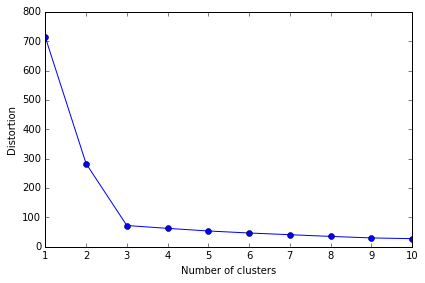

In [13]:
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
#plt.savefig('./figures/elbow.png', dpi=300)
plt.show()

Intuitively, we want to pick the "elbow" part, which achieves best bang for the buck.
* diminishing returns after that elbow/knee point

## Quantifying the quality of clustering  via silhouette plots

Silhouette analysis
* another way to evaluate the quality of clustering

Basic idea
* coherence of each cluster
* separation from other clusters
* high coherence, high separation means good clustering

### Silhouette for clustering

https://en.wikipedia.org/wiki/Silhouette_(clustering)

For each data sample $x^{(i)} \in \mathbf{X}$, we can compute its average distance to a cluster $\mathbf{C} \in \{\mathbf{C}_1, \cdots, \mathbf{C}_k\}$:

$$
\begin{align}
\overline{d}\left(x^{(i)}, \mathbf{C} \right)
&=
\frac{1}{\| \mathbf{C} \|} \sum_{x^{(j)} \in \mathbf{C}} d\left(x^{(i)}, x^{(j)}\right)
\end{align}
$$
, where $d$ is the distance measure (e.g. $L_2$) used for clustering.

We usually skip $x^{(i)}$ comparing against itself, so if $x^{(i)} \in \mathbf{C}$, we have

$$
\begin{align}
\overline{d}\left(x^{(i)}, \mathbf{C} \right)
&=
\frac{1}{\| \mathbf{C} \| - 1} \sum_{x^{(j)} \in \mathbf{C}, j \neq i} d\left(x^{(i)}, x^{(j)}\right)
\end{align}
$$

#### Coherence
$a(i)$: the average distance (dis-similarity) to all other samples within the same cluster:

$$
\begin{align}
a(i) &= \overline{d}\left(x^{(i)}, \mathbf{C} \right)
\\
x^{(i)} &\in \mathbf{C}
\end{align}
$$

#### Separation
$b(i)$: the average distance to the nearest cluster that $x^{(i)}$ does not belong to:

$$
\begin{align}
b(i) &= \min \overline{d}\left(x^{(i)}, \mathbf{C} \right)
\\
\mathbf{C} &\in \{\mathbf{C}_1, \cdots, \mathbf{C}_k \}
\\
x^{(i)} &\not\in \mathbf{C}
\end{align}
$$

#### Silhouette

$s(i)$: the silhouette value of $x^{(i)}$:
$$
\begin{align}
s(i) = \frac{b(i) - a(i)}{\max\left(b(i), a(i)\right)}
\end{align}
$$

Which can be spelled out as:
$$
\begin{align}
s(i) =
\begin{cases}
1 - \frac{a(i)}{b(i)}, & a(i) < b(i)
\\
0, &  a(i) = b(i)
\\
\frac{b(i)}{a(i)} -1, &  a(i) > b(i)
\end{cases}
\end{align}
$$

So
$
-1 \leq s(i) \leq 1
$
* $s(i)$ is close to 1 if we have $a(i) \ll b(i)$ $\rightarrow$ good clustering
* $s(i)$ is close to $-1$ $\rightarrow$ bad clustering

#### Silhouette profile

Plot silhouette values $s(i)$ for all samples $x^{(i)} \in \mathbf{X}$ to visualize the clustering quality.

### Example

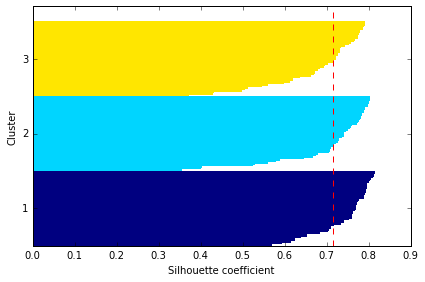

In [14]:
import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples

# clustering
km = KMeans(n_clusters=3, 
            init='k-means++', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X)

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]

# the main part is just one functional call
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')

# visualization
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    # y_ax_lower += len(c_silhouette_vals)
    y_ax_lower = y_ax_upper # Li-yi: clearer meaning
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
# plt.savefig('./figures/silhouette.png', dpi=300)
plt.show()

We want:  
* the average silhouette value to be high
* each cluster to have good silhouette distribution

Comparison to "bad" clustering:

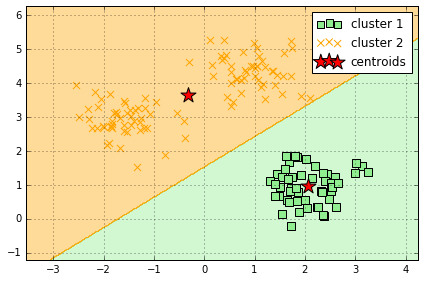

In [15]:
km = KMeans(n_clusters=2,
            init='k-means++',
            n_init=10,
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X)

plot_decision_regions(X, y_km, km)
plot_clusters(X, y_km, km.cluster_centers_)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

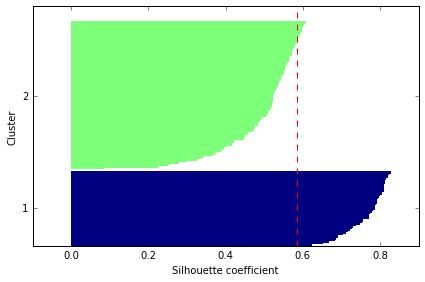

In [16]:
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
# plt.savefig('./figures/silhouette_bad.png', dpi=300)
plt.show()

Notice 
* the low average silhouette value
* one cluster has bad silhouette distribution compared to another

# Organizing clusters as a hierarchical tree

Instead of compute $k$ clusters at once, we can compute them gradually in a hierarchy.

We can decide $k$ later after having the complete hierarchy.

<img src="./images/hierarchical_clustering.svg" width=50% align=right>

## Construction

Two ways to do this:

### Bottom-to-top (agglomerative)
Start with each sample as one cluster, and merge the similar ones until we have one cluster (that contains all samples)

* red $\bigcup$ green $\rightarrow$ yellow
* yellow $\bigcup$ blue $\rightarrow$ cyan

### Top-to-bottom (divisive)
Start with a single cluster (that contains all samples), divide the most diverse one until each sample is in a separate cluster.

* cyan $\rightarrow$ yellow $\bigcup$ blue
* yellow $\rightarrow$ red $\bigcup$ green

## Criteria

How to decide the similarity between two clusters?

### Single linkage

Measure the shortest distance between pairs of samples from the two clusters.

### Complete linkage

Measure the longest distance between pairs of samples from the two clusters.

<img src='./images/11_05.png' width=80%> 

### Other possibilities

Ward's linkage: MSE of clusters
$$
\begin{align}
E\left(\mathbf{X} , \mathbf{U} \right)
&=
\sum_i \sum_j w^m_{ij} d\left(x^{(i)}, \mu^{(j)}\right)
\end{align}
$$

## Agglomerative clustering


## Example

In [17]:
import pandas as pd
import numpy as np

np.random.seed(123)

variables = ['X', 'Y', 'Z']
labels = ['ID_0', 'ID_1', 'ID_2', 'ID_3', 'ID_4']

X = np.random.random_sample([5, 3])*10
df = pd.DataFrame(X, columns=variables, index=labels)
df

,X,Y,Z
ID_0,6.964692,2.861393,2.268515
ID_1,5.513148,7.194690,4.231065
ID_2,9.807642,6.848297,4.809319
ID_3,3.921175,3.431780,7.290497
ID_4,4.385722,0.596779,3.980443


## Performing hierarchical clustering on a distance matrix

In [18]:
from scipy.spatial.distance import pdist, squareform

row_dist = pd.DataFrame(squareform(pdist(df, metric='euclidean')),
                        columns=labels,
                        index=labels)
row_dist

,ID_0,ID_1,ID_2,ID_3,ID_4
ID_0,0.000000,4.973534,5.516653,5.899885,3.835396
ID_1,4.973534,0.000000,4.347073,5.104311,6.698233
ID_2,5.516653,4.347073,0.000000,7.244262,8.316594
ID_3,5.899885,5.104311,7.244262,0.000000,4.382864
ID_4,3.835396,6.698233,8.316594,4.382864,0.000000


## Linkage usage

Either one of these will do:
* pass a condensed distance matrix (upper triangular) from the `pdist` function
* pass the "original" data array and define the `metric='euclidean'` argument in `linkage`

However, we should not pass the squareform distance matrix, which would yield different distance values although the overall clustering could be the same.

In [19]:
from scipy.cluster.hierarchy import linkage

help(linkage)

Help on function linkage in module scipy.cluster.hierarchy:

linkage(y, method='single', metric='euclidean')
    Performs hierarchical/agglomerative clustering on the condensed
    distance matrix y.
    
    y must be a :math:`{n \choose 2}` sized
    vector where n is the number of original observations paired
    in the distance matrix. The behavior of this function is very
    similar to the MATLAB linkage function.
    
    An :math:`(n-1)` by 4  matrix ``Z`` is returned. At the
    :math:`i`-th iteration, clusters with indices ``Z[i, 0]`` and
    ``Z[i, 1]`` are combined to form cluster :math:`n + i`. A
    cluster with an index less than :math:`n` corresponds to one of
    the :math:`n` original observations. The distance between
    clusters ``Z[i, 0]`` and ``Z[i, 1]`` is given by ``Z[i, 2]``. The
    fourth value ``Z[i, 3]`` represents the number of original
    observations in the newly formed cluster.
    
    The following linkage methods are used to compute the distance
  

In [20]:
# 1. incorrect approach: Squareform distance matrix

from scipy.cluster.hierarchy import linkage

row_clusters = linkage(row_dist, method='complete', metric='euclidean')
pd.DataFrame(row_clusters,
             columns=['row label 1', 'row label 2',
                      'distance', 'no. of items in clust.'],
             index=['cluster %d' % (i + 1)
                    for i in range(row_clusters.shape[0])])

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,6.521973,2.0
cluster 2,1.0,2.0,6.729603,2.0
cluster 3,3.0,5.0,8.539247,3.0
cluster 4,6.0,7.0,12.444824,5.0


In [21]:
# 2. correct approach: Condensed distance matrix

row_clusters = linkage(pdist(df, metric='euclidean'), method='complete')
pd.DataFrame(row_clusters,
             columns=['row label 1', 'row label 2',
                      'distance', 'no. of items in clust.'],
             index=['cluster %d' % (i + 1) 
                    for i in range(row_clusters.shape[0])])

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,3.835396,2.0
cluster 2,1.0,2.0,4.347073,2.0
cluster 3,3.0,5.0,5.899885,3.0
cluster 4,6.0,7.0,8.316594,5.0


In [22]:
# 3. correct approach: Input sample matrix

row_clusters = linkage(df.values, method='complete', metric='euclidean')
pd.DataFrame(row_clusters,
             columns=['row label 1', 'row label 2',
                      'distance', 'no. of items in clust.'],
             index=['cluster %d' % (i + 1)
                    for i in range(row_clusters.shape[0])])

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,3.835396,2.0
cluster 2,1.0,2.0,4.347073,2.0
cluster 3,3.0,5.0,5.899885,3.0
cluster 4,6.0,7.0,8.316594,5.0


The ids in each row correspond to a leaf (data sample) or an internal node (cluster).

In this example, id 0 to 4 correspond to the original 5 samples.

Clusters are formed bottom up with id from 5 and increasing up.

The dendrogam can also help visualization.

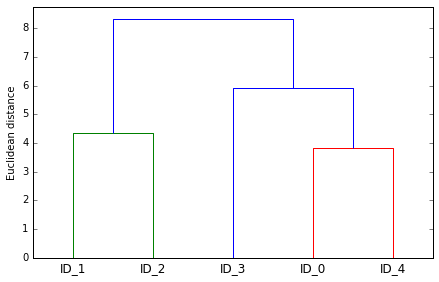

In [23]:
from scipy.cluster.hierarchy import dendrogram

# make dendrogram black (part 1/2)
# from scipy.cluster.hierarchy import set_link_color_palette
# set_link_color_palette(['black'])

row_dendr = dendrogram(row_clusters, 
                       labels=labels,
                       # make dendrogram black (part 2/2)
                       # color_threshold=np.inf
                       )
plt.tight_layout()
plt.ylabel('Euclidean distance')
#plt.savefig('./figures/dendrogram.png', dpi=300, 
#            bbox_inches='tight')
plt.show()

## Attaching dendrograms to a heat map

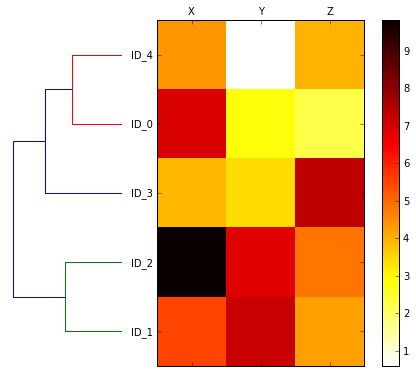

In [24]:
# plot row dendrogram
fig = plt.figure(figsize=(8, 8), facecolor='white')
axd = fig.add_axes([0.09, 0.1, 0.2, 0.6])

# note: for matplotlib < v1.5.1, please use orientation='right'
row_dendr = dendrogram(row_clusters, orientation='left')

# reorder data with respect to clustering
df_rowclust = df.ix[row_dendr['leaves'][::-1]]
axd.set_xticks([])
axd.set_yticks([])

# remove axes spines from dendrogram
for i in axd.spines.values():
        i.set_visible(False)

# plot heatmap
axm = fig.add_axes([0.23, 0.1, 0.6, 0.6])  # x-pos, y-pos, width, height
cax = axm.matshow(df_rowclust, interpolation='nearest', cmap='hot_r')
fig.colorbar(cax)
axm.set_xticklabels([''] + list(df_rowclust.columns))
axm.set_yticklabels([''] + list(df_rowclust.index))

# plt.savefig('./figures/heatmap.png', dpi=300)
plt.show()

## Applying agglomerative clustering via scikit-learn

As usual, coding in scikit-learn is pretty simple.

In [25]:
from sklearn.cluster import AgglomerativeClustering

ac = AgglomerativeClustering(n_clusters=2, # number of final clusters 
                             affinity='euclidean', 
                             linkage='complete')
labels = ac.fit_predict(X)
print('Cluster labels: %s' % labels)
print(ac.children_)

Cluster labels: [0 1 1 0 0]
[[0 4]
 [1 2]
 [3 5]
 [6 7]]


The clustering result is consistent with the dendogram above.

# Locating regions of high density via DBSCAN

Density-based Spatial Clustering of Applications with Noise

A form of clustering different from k-means and hierarhical clustering
* more resilient to noise
* allows general cluster shapes

<img src='./images/11_11.png' width=70%> 

https://youtu.be/5E097ZLE9Sg?t=1m35s

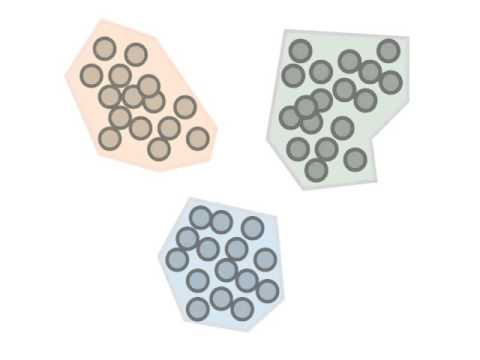

In [26]:
from IPython.display import YouTubeVideo
YouTubeVideo('5E097ZLE9Sg')

## Parameters

* $\epsilon$: neighborhood within radius $\epsilon$ of each sample point
* MinPts: minimum number of points within neighborhood to be considered as "dense" enough

These two define sample density.

## Definitions

### Core point
* at least MinPts of samples within radius $\epsilon$

### Border point
* fewer than MinPts within radius $\epsilon$
* but within $\epsilon$ of a core point

### Noise point
* everything else

## Algorithm

Form a separate cluster for each core point or a connected group of core points.
* Two core points are connected if they are within $\epsilon$ from each other.

Assign each border point to the cluster of its corresponding core point.

Ignore noise points.

## Example

Comparing k-means, hierarchical, and density-based clustering.

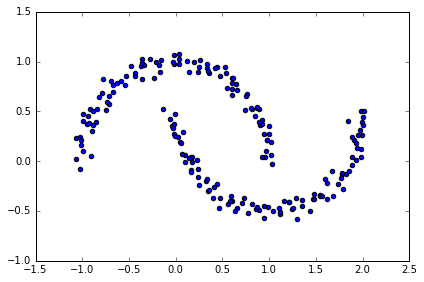

In [27]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=200, noise=0.05, random_state=0)
plt.scatter(X[:, 0], X[:, 1])
plt.tight_layout()
# plt.savefig('./figures/moons.png', dpi=300)
plt.show()

K-means and hierarchical clustering:

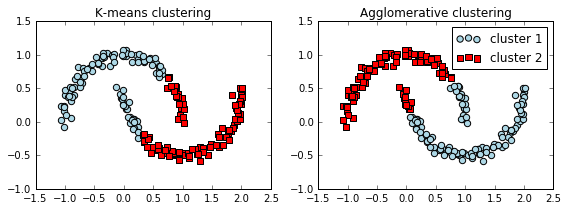

In [28]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

km = KMeans(n_clusters=2, random_state=0)
y_km = km.fit_predict(X)
ax1.scatter(X[y_km == 0, 0], X[y_km == 0, 1],
            c='lightblue', marker='o', s=40, label='cluster 1')
ax1.scatter(X[y_km == 1, 0], X[y_km == 1, 1],
            c='red', marker='s', s=40, label='cluster 2')
ax1.set_title('K-means clustering')

ac = AgglomerativeClustering(n_clusters=2,
                             affinity='euclidean',
                             linkage='complete')
y_ac = ac.fit_predict(X)
ax2.scatter(X[y_ac == 0, 0], X[y_ac == 0, 1], c='lightblue',
            marker='o', s=40, label='cluster 1')
ax2.scatter(X[y_ac == 1, 0], X[y_ac == 1, 1], c='red',
            marker='s', s=40, label='cluster 2')
ax2.set_title('Agglomerative clustering')

plt.legend()
plt.tight_layout()
#plt.savefig('./figures/kmeans_and_ac.png', dpi=300)
plt.show()

Intuitively, the two moons should form two separate clusters.

But geometric distance of k-means and hierarchical clustering might group the wrong parts together.

Density-based clustering considers the topology of the clusters:

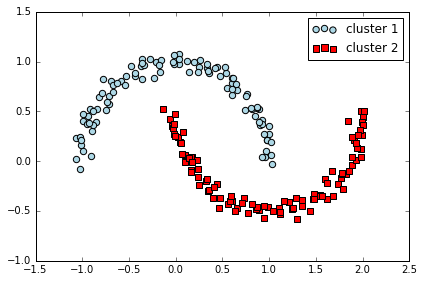

In [29]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.2, min_samples=5, metric='euclidean')
y_db = db.fit_predict(X)
plt.scatter(X[y_db == 0, 0], X[y_db == 0, 1],
            c='lightblue', marker='o', s=40,
            label='cluster 1')
plt.scatter(X[y_db == 1, 0], X[y_db == 1, 1],
            c='red', marker='s', s=40,
            label='cluster 2')
plt.legend()
plt.tight_layout()
#plt.savefig('./figures/moons_dbscan.png', dpi=300)
plt.show()

## Disadvantages of density-based clustering

Two hyper-parameters ($\epsilon$ and MinPts) to tune
* versus one $k$ for k-means and hierarhical clustering
* aside from distance measure as another hyper parameter

Does not have a predict() method
* non-parametric, applies to the current dataset only

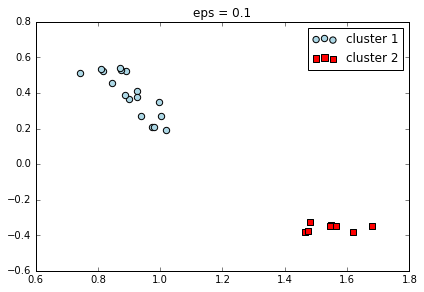

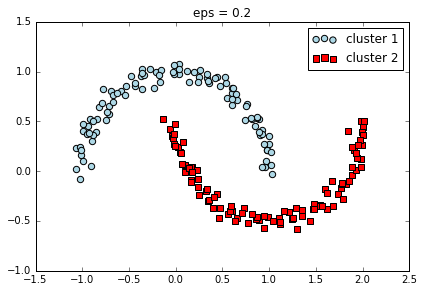

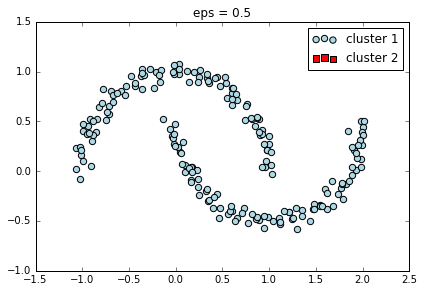

In [30]:
from sklearn.cluster import DBSCAN

eps_values = [0.1, 0.2, 0.5]

for eps_value in eps_values:
    db = DBSCAN(eps=eps_value, min_samples=5, metric='euclidean')
    y_db = db.fit_predict(X)
    plt.scatter(X[y_db == 0, 0], X[y_db == 0, 1],
                c='lightblue', marker='o', s=40,
                label='cluster 1')
    plt.scatter(X[y_db == 1, 0], X[y_db == 1, 1],
                c='red', marker='s', s=40,
                label='cluster 2')
    plt.legend()
    plt.tight_layout()
    plt.title('eps = ' + str(eps_value))
    plt.show()

# Summary

Clustering is a non-supervised learning method.

Three main types of clustering with different flavors and trade-offs:
* k-means
* hierarchical
* density-based

# Application to real dataset

We have been using a synthetic data set (random blobs) so far.

Let's try apply clustering to a read data set: handwritten digits.
* each digit image came with a label for supervised learning
* large datasets can be expensive to label manually

Solution
* cluster first
* manually label a few samples within each cluster
* propagate the labels for the rest

Verification
* use a dataset with labels
* ignore the labels and just cluster
* would the clusters agree with the labels?

<a href="https://github.com/cazala/mnist/blob/master/README.md">
<img src="https://camo.githubusercontent.com/d440ac2eee1cb3ea33340a2c5f6f15a0878e9275/687474703a2f2f692e7974696d672e636f6d2f76692f3051493378675875422d512f687164656661756c742e6a7067">
</a>

# Reading

* PML Chapter 11
* IML Chapter 7.3, 7.7, 7.8